## Motive

The objective of the emotion classification is to classify different emotions from the speech signal. A person’s emotional state affects the production mechanism of speech, and due to this, breathing rate and muscle tension change from the neutral condition. Therefore, the resulting speech signal may have different characteristics from that of neutral speech.

The performance of speech recognition or speaker recognition decreases significantly if the model is trained with neutral speech and it is tested with an emotional speech.

In [1]:
# import necessary packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import glob
import os
import json
import math
import random

import librosa
from librosa.util import normalize as normalize
import librosa.display

from scipy.io import wavfile

import torch  as torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils as vutils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import  Variable as Variable

import IPython.display as ipd

# Set random seed for reproducibility
manualseed = 999
print('Random Seed: ', manualseed)
torch.manual_seed(manualseed)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("\nrunning on:", device)

Random Seed:  999

running on: cpu


In [5]:
class Args:
    n_mfcc=13
    n_fft=2048
    hop_size=512
    num_segments=5
    batch_size=16
    
h = Args()

In [575]:
audio_path = 'data/emotions/wav/*.wav'
save_mfcc_path = 'data/emotions/mfcc_data/'

## Utils

In [434]:
def plot_time_domain(audio, sample_rate):

    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)

    plt.grid(True)
    
    
def plot_freq_domain(frequency, magnitude):
    plt.plot(frequency, magnitude)
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Power')
    plt.show();
    
def plot_spectrogram(spectrogram, y_label, title='Plot', h=h, sr=sample_rate):
    plt.figure(figsize=(20, 7))
    librosa.display.specshow(spectrogram, sr=sr, hop_length=h.hop_size)
    plt.xlabel('Time')
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.colorbar()
    plt.show()

In [8]:
# loop through data
def findFiles(path): return glob.glob(path)

In [9]:
def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

In [171]:
def play_audio(au, sr=None):
    return ipd.Audio(au, rate=sr)

## Look through data

Here is an emotional speech wav fils that contains 535 utterances spoken by actors in german language.

The EMODB database comprises of seven emotions: 

1) anger; 2) boredom; 3) anxiety; 4) happiness; 5) sadness; 6) disgust; and 7) neutral.
The data was recorded at a 48-kHz sampling rate and then down-sampled to 16-kHz.

But ive processed it into  MFCCs and saved as .npy file.


In [568]:
emo_lookup = {'W': 'anger', 'L':'boredom', 'E':'disgust',
               'A':'anxiety', 'F':'happiness',
               'T':'sadness',  'N':'neutral'}

letter_to_index = {_:i for i, _ in enumerate(emo_lookup)}
index_to_letter = dict(enumerate(emo_lookup))

In [569]:
letter_to_index

{'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6}

In [570]:
index_to_letter

{0: 'W', 1: 'L', 2: 'E', 3: 'A', 4: 'F', 5: 'T', 6: 'N'}

In [10]:
# hold all wav files
audio_data = [_ for _ in findFiles(audio_path)]

print('total audios in data:',len(audio_data))

total audios in data: 535


In [11]:
audio_data[1]

'data/emotions/wav\\03a01Nc.wav'

In [227]:
sample_rate, audio = wavfile.read(audio_data[1])

In [228]:
print(f"number of channels = {audio.shape}")

time = audio.shape[0] / sample_rate
print(f"length = {time}s")

length = np.arange(0, audio.shape[0]) / sample_rate

print(f'Sample rate: {sample_rate}Hz')


number of channels = (25780,)
length = 1.61125s
Sample rate: 16000Hz


In [19]:
def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

In [21]:
audio = normalize_audio(audio)


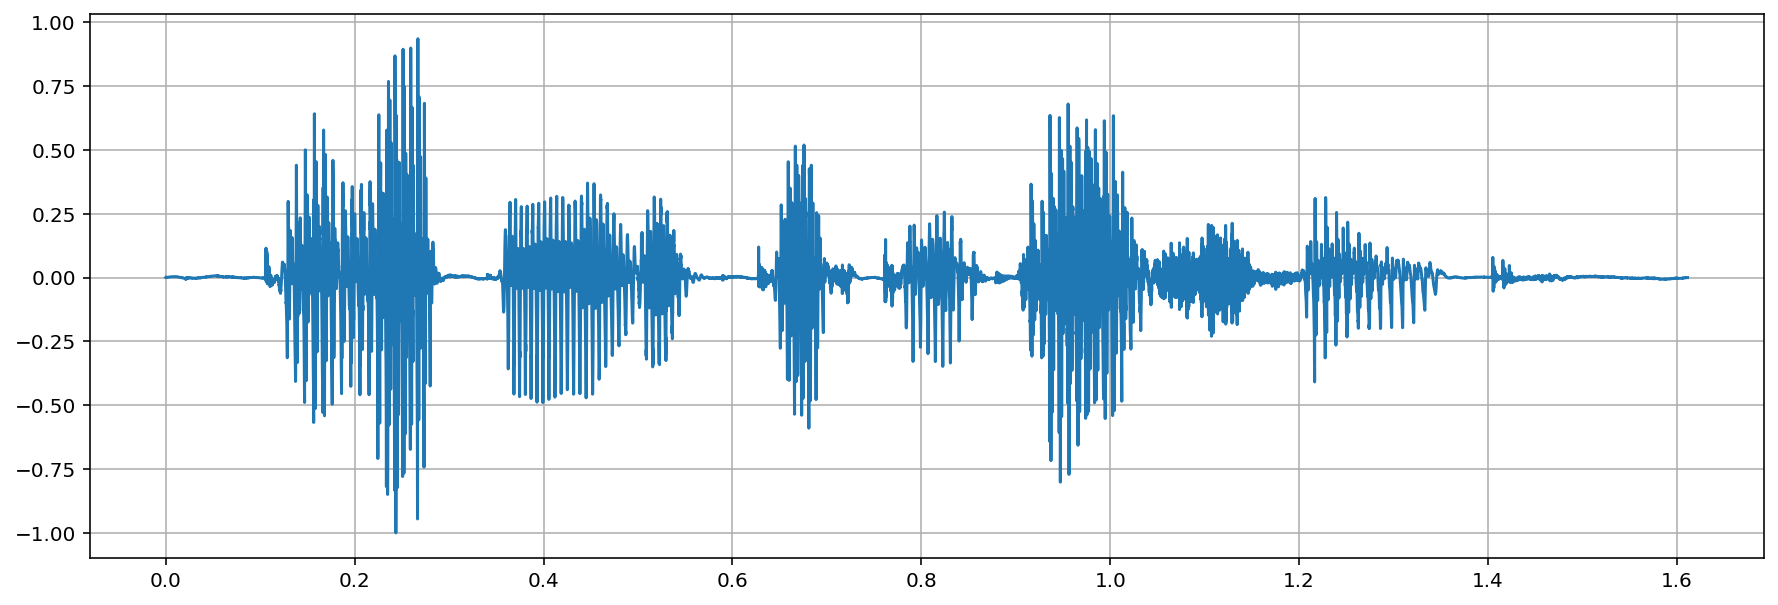

In [22]:
plot_time_domain(audio, sample_rate)

## Preparing the Dataset

In [229]:
# hyper params
SAMPLE_RATE = sample_rate # 22050
DURATION = time # measured in seconds
SAMPLES_PER_AUDIO = SAMPLE_RATE / DURATION

MAX_WAV_VALUE = 32768.0

In [230]:
(SAMPLES_PER_AUDIO/2) 

4965.089216446858

In [669]:
audio.size

25780

In [726]:
def frame_audio(audio, n_fft, hop_size, sample_rate):
    
        audio = np.pad(audio, (int(n_fft-hop_size / 2), int(n_fft-hop_size / 2)), 
                               mode='reflect')
        
        frame_len = np.round(sample_rate * hop_size / 100).astype(int)
        frame_num = int((len(audio) - n_fft) / frame_len) + 1
        frames = np.zeros((frame_num, n_fft))
        
        for i in range(frame_num):
            frames[i] = audio[i*frame_len:i*frame_len+n_fft]
            
        return frames

In [728]:
def saveMfcc(audio_path, save_mfcc_path, n_mfcc=13,
             n_fft=h.n_fft, hop_size=512, sample_rate=None):

    assert sample_rate != None, 'Wheres your sample rate?'
    
    num_samples_per_segment = int(SAMPLES_PER_AUDIO / 2) # 2540, segement_size
    
    for i, file in enumerate(findFiles(audio_path)):
    
        semantic_label = os.path.split(file)[1].split('.')[0][5:-1]

        label = emo_lookup[semantic_label]
        
        
        print(f'\nProcessing {label} #{i+1}')
        
        # load audio file) 
        _, signal = wavfile.read(file)
        
        signal = signal / MAX_WAV_VALUE
        
        signal = normalize_audio(signal) * 0.95
        
        if signal.size < sample_rate:
             # add silence
            signal = np.pad(wav, (sample_rate - signal.size, 0), mode='constant')
        else:
            # scrap from sample_rate length
            signal = signal[0:sample_rate]
            

        # we used 15 because the length of the audio is less than 2s
        signal = frame_audio(signal, n_fft, 15, sample_rate).flatten()

        mfcc = librosa.feature.mfcc(signal, sr=sample_rate,n_fft=n_fft,
                                   n_mfcc=n_mfcc, hop_length=512)
        
        mfcc = mfcc.T
        
        np.save(save_mfcc_path + label + '_' + semantic_label + '_' + str(i),
                mfcc)

        
saveMfcc(audio_path, save_mfcc_path, sample_rate=sample_rate)       



Processing happiness #1

Processing neutral #2

Processing anger #3

Processing happiness #4

Processing neutral #5

Processing sadness #6

Processing anger #7

Processing anger #8

Processing anxiety #9

Processing happiness #10

Processing boredom #11

Processing neutral #12

Processing sadness #13

Processing anger #14

Processing anxiety #15

Processing happiness #16

Processing neutral #17

Processing sadness #18

Processing anger #19

Processing anger #20

Processing happiness #21

Processing happiness #22

Processing boredom #23

Processing neutral #24

Processing anger #25

Processing happiness #26

Processing boredom #27

Processing neutral #28

Processing sadness #29

Processing anger #30

Processing anger #31

Processing anxiety #32

Processing boredom #33

Processing neutral #34

Processing sadness #35

Processing anger #36

Processing neutral #37

Processing sadness #38

Processing anger #39

Processing boredom #40

Processing neutral #41

Processing sadness #42

Processi


Processing boredom #336

Processing neutral #337

Processing anger #338

Processing anger #339

Processing anxiety #340

Processing anxiety #341

Processing disgust #342

Processing neutral #343

Processing anger #344

Processing anger #345

Processing anxiety #346

Processing disgust #347

Processing happiness #348

Processing boredom #349

Processing neutral #350

Processing sadness #351

Processing anger #352

Processing anger #353

Processing anxiety #354

Processing disgust #355

Processing boredom #356

Processing sadness #357

Processing sadness #358

Processing anger #359

Processing anger #360

Processing anxiety #361

Processing anxiety #362

Processing happiness #363

Processing happiness #364

Processing boredom #365

Processing neutral #366

Processing sadness #367

Processing sadness #368

Processing anger #369

Processing anger #370

Processing anxiety #371

Processing disgust #372


C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.



Processing happiness #373

Processing boredom #374

Processing boredom #375

Processing neutral #376

Processing sadness #377

Processing anger #378

Processing anxiety #379

Processing disgust #380

Processing happiness #381

Processing happiness #382

Processing neutral #383

Processing anger #384

Processing anxiety #385

Processing happiness #386

Processing neutral #387

Processing sadness #388

Processing anger #389

Processing anger #390

Processing anxiety #391

Processing disgust #392

Processing boredom #393

Processing sadness #394

Processing anger #395

Processing anxiety #396

Processing disgust #397

Processing happiness #398

Processing boredom #399

Processing sadness #400

Processing anger #401

Processing anger #402

Processing anxiety #403

Processing disgust #404

Processing boredom #405

Processing neutral #406

Processing sadness #407

Processing anger #408

Processing disgust #409

Processing happiness #410

Processing boredom #411

Processing neutral #412

Pro

In [729]:
# take a look at the processed mfcc
x = np.load(save_mfcc_path+'happiness_F_0.npy')

In [730]:
x.shape

(33, 13)

In [731]:
np.load(save_mfcc_path+'neutral_N_1.npy.').shape

(33, 13)

In [732]:
x = x.T # flip to landscape view

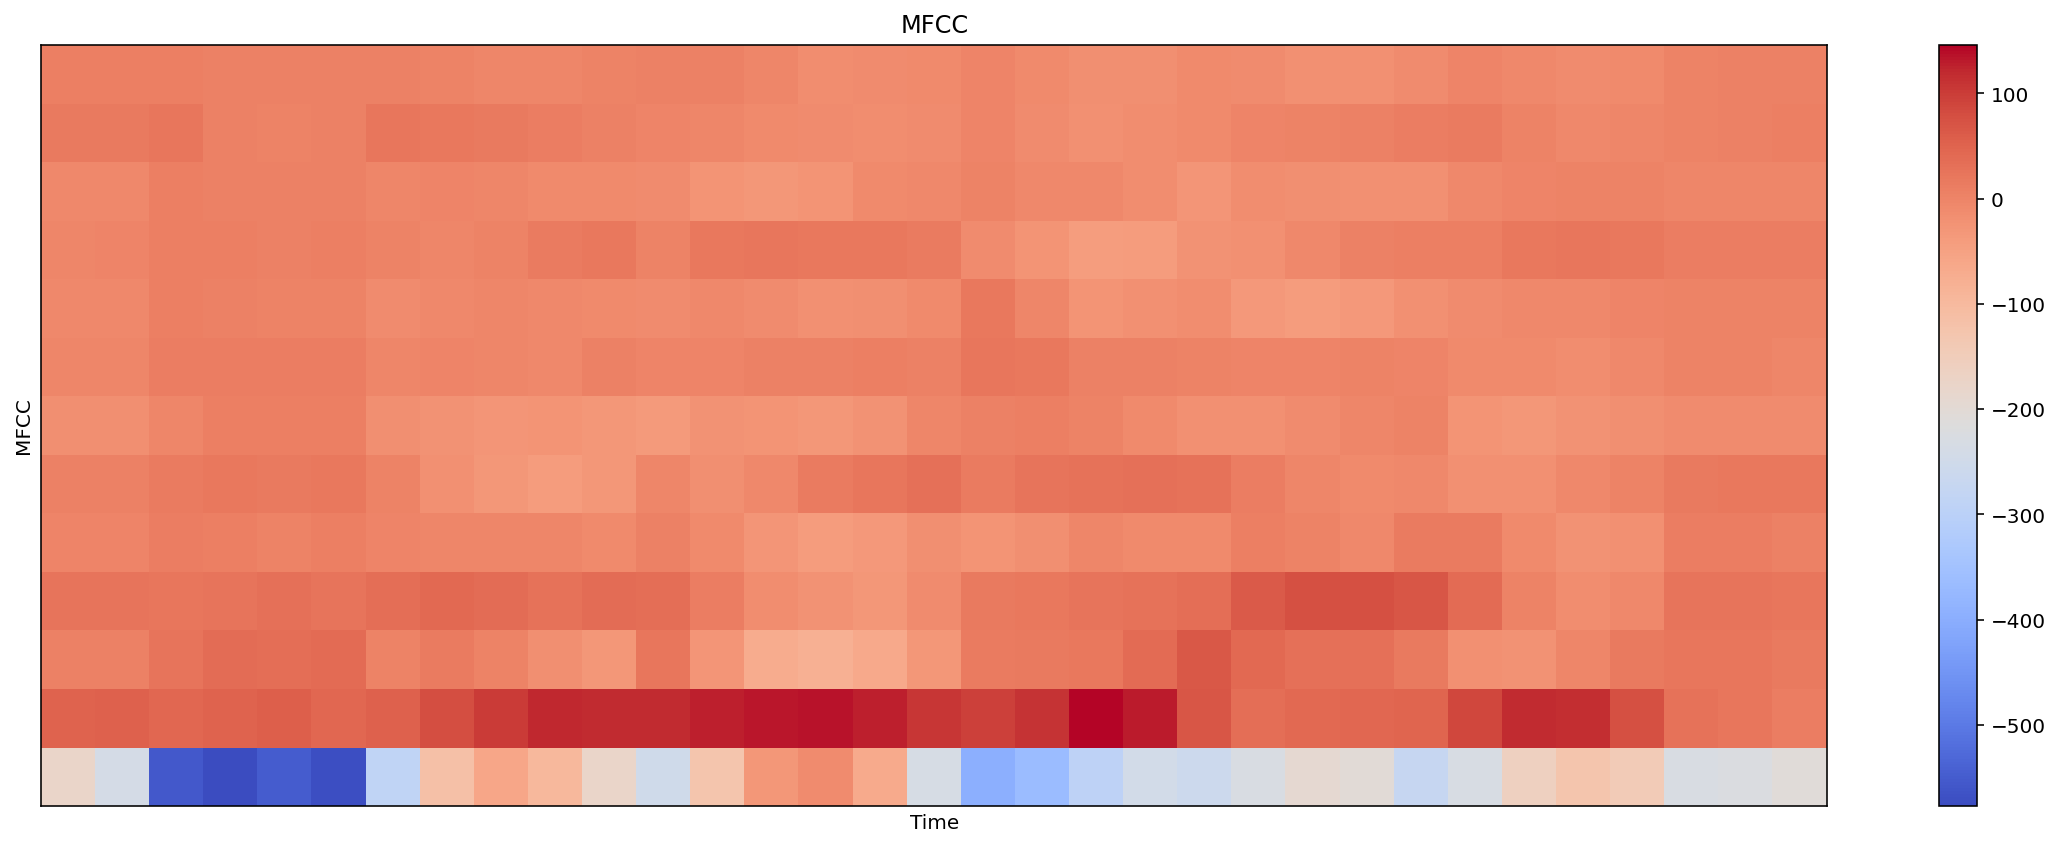

In [733]:
plot_spectrogram(x,'MFCC', 'MFCC')

In [734]:
t = librosa.feature.inverse.mfcc_to_audio(x)

In [735]:
# why sounds different?
# mfcc is better used for classification and other detections
play_audio(t, sample_rate)

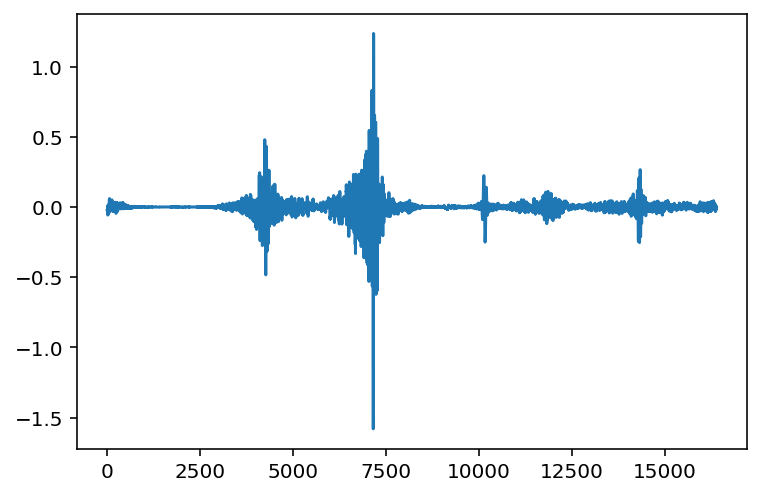

In [736]:
plt.plot(t)
plt.show();

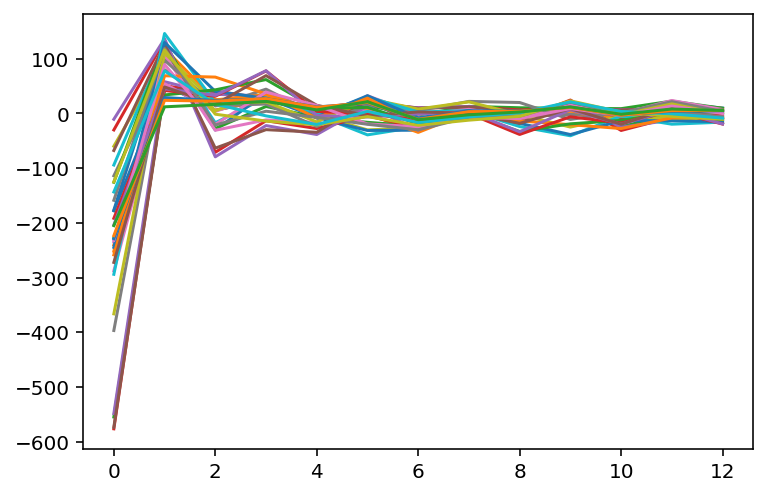

In [737]:
# mel filterbands
plt.plot(x)
plt.show();

## Load Data

In [774]:
class AudioDataset(Dataset):
    
    def __init__(self, data=None, sample_rate=0, data_processed=True):

        self.audio_files = findFiles(data)
        self.sample_rate = sample_rate
        self.data_processed = data_processed
        
        
    def __getitem__(self, index):
        
        filename = self.audio_files[index]
        
        
        # tweak code if usng a new audio
        if not self.data_processed:
            semantic_label = os.path.split(filename)[1].split('.')[0][5:-1]

            label = emo_lookup[semantic_label]
       
            # load audio file) 
            sample_rate, signal = wavfile.read(file)
            
            
            assert sample_rate != self.sample_rate, f'{sample_rate} Sample rate doesnt match target{self.sample_rate}'

            signal = signal / MAX_WAV_VALUE

            signal = normalize_audio(signal) * 0.95
            
            if signal.size < sample_rate:
                # add silence
                signal = np.pad(wav, (sample_rate - signal.size, 0), mode='constant')
            else:
                # scrap from sample_rate length
                signal = signal[0:sample_rate]


            # we used 15 because the length of the audio is less than 2s
            signal = frame_audio(signal, n_fft, 15, sample_rate).flatten()

            mfcc = librosa.feature.mfcc(signal, sr=sample_rate,n_fft=n_fft,
                                       n_mfcc=n_mfcc, hop_length=512)

            mfcc = mfcc.T
        
        
            
            x = torch.from_numpy(x)
            x = torch.FloatTensor(x).unsqueeze(0)
            
            y = torch.LongTensor(letter_to_index[semantic_label])
        
        else:
            
            assert filename != None, 'Wheres the processed audio file?'
            
            mfcc = np.load(filename)
                    
            x = torch.from_numpy(mfcc).unsqueeze(0) # 4d array-> (batch_size, C, H, W)
            
            semantic_label = os.path.splitext(filename)[0].split('_')[-2]
            y = letter_to_index[semantic_label]
            
            
        return x, y
    
    
    def __len__(self):
        return len(self.audio_files)

In [776]:
# audio_path = 'data/emotions/mfcc_data'
base_mfccs_path = 'data/emotions/mfcc_data/*.npy'


full_dataset = AudioDataset(base_mfccs_path, sample_rate)

# build partion -- train test split
lengths = [int(len(full_dataset)*0.8), int(len(full_dataset)*0.2)]
print(f'train size: {lengths[0]} \ntest size: {lengths[1]}')

train_subset, test_subset = torch.utils.data.random_split(full_dataset, lengths)


train_loader = torch.utils.data.DataLoader(train_subset, batch_size=8, drop_last=True,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=8, drop_last=True, 
                                          shuffle=True)

train size: 428 
test size: 107


In [777]:
au, lb = next(iter(train_loader))

au[0], lb[0]

(tensor([[[-1.1429e+02,  9.0907e+01, -8.8144e+01, -1.8353e+01, -3.4400e+01,
           -7.1678e+00, -1.5812e+01, -5.2863e+00, -4.6332e+00,  4.2761e+00,
            5.5164e+00, -1.2655e+01, -2.5621e+00],
          [-1.4314e+02,  9.5201e+01, -6.9072e+01, -1.2668e+01, -2.3373e+01,
           -5.9071e+00, -1.2077e+01, -7.8429e-01,  1.0879e+00,  6.1919e+00,
            8.6338e+00, -1.4112e+01, -2.0477e+00],
          [-2.8660e+02,  8.9651e+01, -1.9285e+01,  5.8094e+00, -2.2345e+00,
           -1.3635e+01, -1.8696e+01,  4.6398e+00,  4.3368e+00,  1.4639e+01,
            1.3311e+01, -1.2772e+01, -5.3926e+00],
          [-5.1399e+02,  6.3546e+01,  1.6762e+01,  5.4298e+01,  6.2521e+00,
            7.2495e+00,  3.2124e+01,  5.6877e+00, -1.8215e+01,  7.8574e+00,
            5.8158e+00, -3.4704e-01,  1.0561e+01],
          [-5.0340e+02,  5.9731e+01,  8.3532e+00,  5.6254e+01,  5.2498e+00,
            6.6588e+00,  3.3110e+01,  6.2247e+00, -1.7512e+01,  6.3296e+00,
            2.7218e+00,  7.4725e-01,

In [778]:
au, lb = next(iter(test_loader))

au[0], lb[0]

(tensor([[[-3.1034e+02,  4.9637e+01, -7.5693e+01, -6.6108e-01,  2.2393e+01,
            1.4050e+01,  3.8940e+00,  1.0338e+01,  1.9418e+01,  4.5686e+00,
            1.0961e+01,  2.2346e+01, -1.3227e+01],
          [-3.7000e+02,  5.2309e+01, -7.3045e+01,  2.4196e+00,  2.6101e+01,
            1.8172e+01,  8.2973e+00,  1.3202e+01,  1.8656e+01,  7.9021e+00,
            1.3271e+01,  2.4880e+01, -9.4973e+00],
          [-5.1376e+02,  5.2459e+01, -1.3564e+01,  9.3959e+00,  3.7181e+01,
            2.5535e+01,  9.5560e+00,  1.0598e+01,  1.9813e+01,  1.2781e+01,
            3.8565e+00,  1.1771e+01,  9.0191e+00],
          [-4.9304e+02,  6.3652e+01, -2.0155e+01,  4.5039e+00,  2.8733e+01,
            1.2427e+01, -2.5768e+00,  7.2829e+00,  2.6859e+01,  1.2030e+01,
           -3.1841e+00,  1.1882e+01,  6.8812e+00],
          [-4.8901e+02,  6.7293e+01, -1.8630e+01,  4.3155e+00,  2.6545e+01,
            1.1188e+01, -3.0605e+00,  7.1332e+00,  2.7025e+01,  1.0643e+01,
           -3.5111e+00,  1.2668e+01,

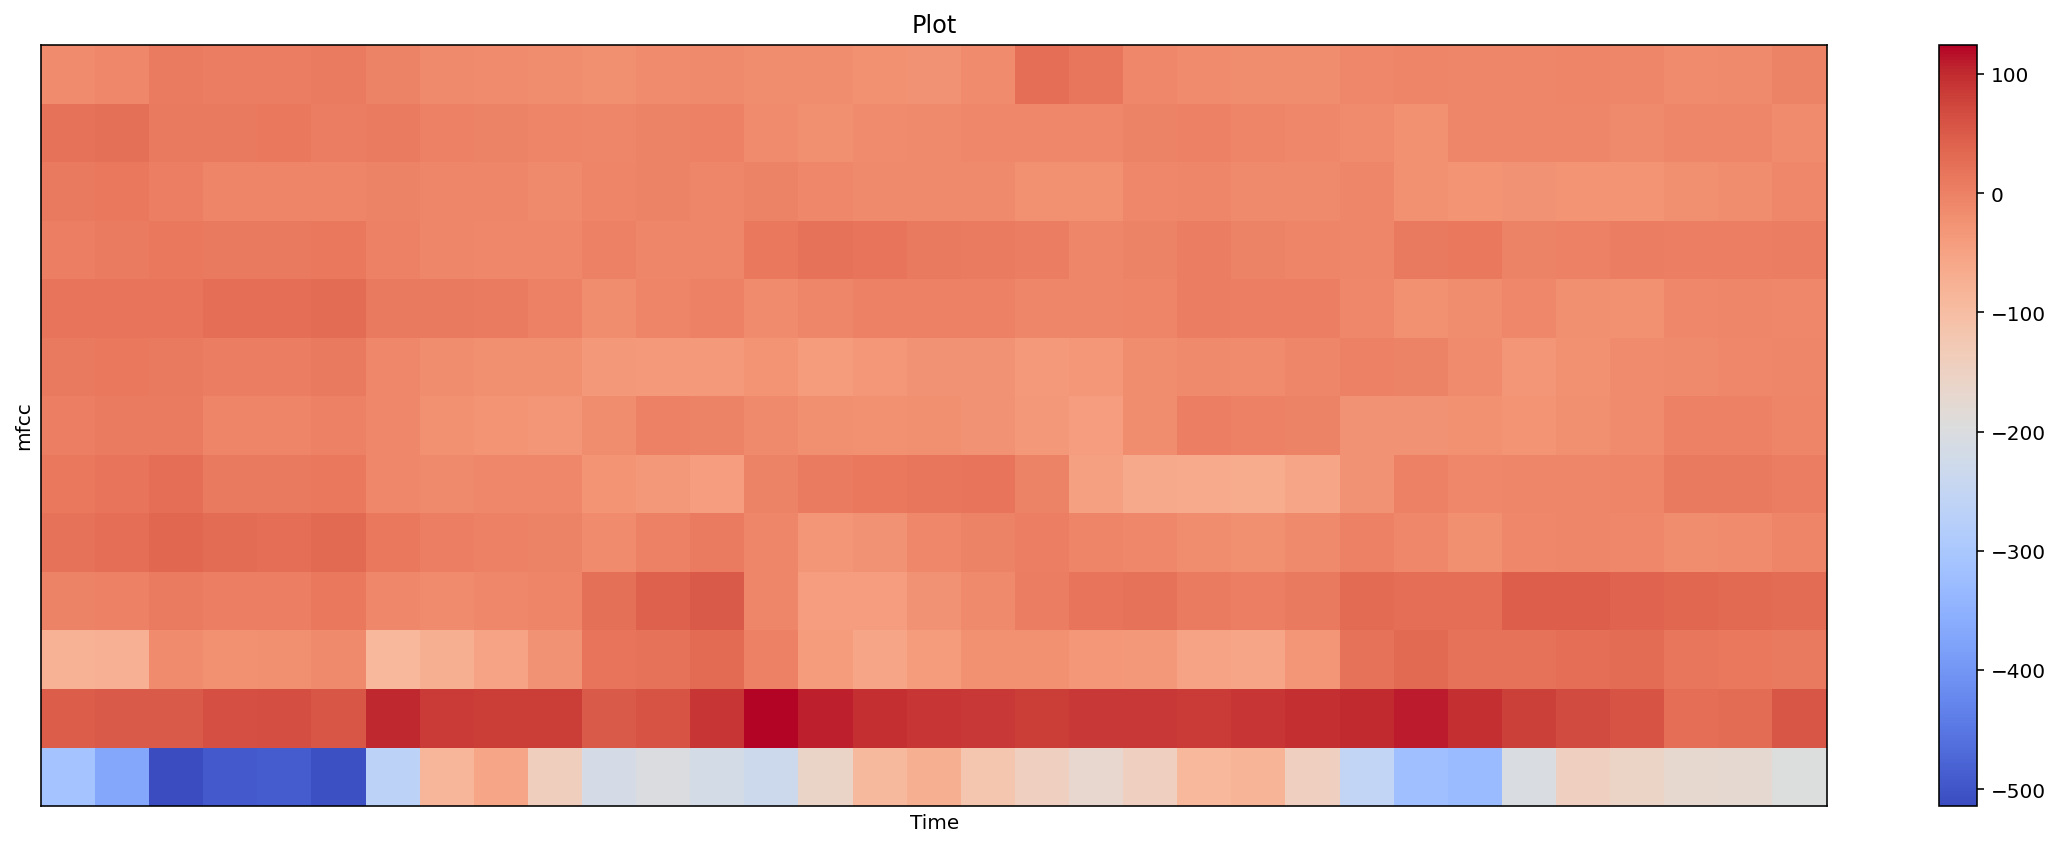

In [779]:
plot_spectrogram(au[0].squeeze().numpy().T,'mfcc')

## Build Model

using a MLP

In [819]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        
        self.main = nn.Sequential(
            
            # hidden layer
            nn.Linear(429, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            # 2 input layer
            nn.Linear(512, 256),
            nn.ReLU(),            
            nn.Dropout(p=0.3),
            
            # 3 input layer
            nn.Linear(256, 65),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            # output layer
            nn.Linear(65, 7)    
        )
        
    def forward(self, x):
        
        x = x.view(x.size(0), -1)
        
        x = self.main(x)
        
    
        return F.log_softmax(x, dim=1)

mlp = MLP()
mlp

MLP(
  (main): Sequential(
    (0): Linear(in_features=429, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=65, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=65, out_features=7, bias=True)
  )
)

In [820]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(mlp.parameters(), lr=3e-4)

In [821]:
# calculate accuracy before training
correct = 0
total = 0

for mfcc, targets in test_loader:
    
    # forward pass to get log_probs
    log_probs = mlp(mfcc.float())
    
    # get the predicted class from the maximum value
    # in the output-list of class scores
    _, predicted = torch.max(log_probs.data, 1)
    
    # count up total # of correct targets
    # for which the predicted and true are equal
    total += targets.size(0)
    correct += (predicted == targets).sum()
    
    
# calc. accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

print('Accuracy before training: ', accuracy)

Accuracy before training:  10.576923076923077


In [822]:
def train_network(model):
    epochs = 50
    running_loss = 0
    print_every = 40
    
    loss_over_time = [] # to track the loss as the network trains

  

    for e in range(epochs):
        
        running_loss = 0.0

        for i, (mfcc, targets) in enumerate(train_loader):
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            log_prob = model(mfcc.float())
    
            #calculate the loss
            loss = criterion(log_prob, targets.long())
            
            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if i % print_every == 39:    # print every 100 batches
                avg_loss = running_loss/print_every
                # record and print the avg loss over the 100 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(e + 1, i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time
        
# call train
training_loss = train_network(mlp)

Epoch: 1, Batch: 40, Avg. Loss: 3.1377711981534957
Epoch: 2, Batch: 40, Avg. Loss: 2.0125929415225983
Epoch: 3, Batch: 40, Avg. Loss: 1.809607556462288
Epoch: 4, Batch: 40, Avg. Loss: 1.6299550384283066
Epoch: 5, Batch: 40, Avg. Loss: 1.5399394541978837
Epoch: 6, Batch: 40, Avg. Loss: 1.400798425078392
Epoch: 7, Batch: 40, Avg. Loss: 1.329804228246212
Epoch: 8, Batch: 40, Avg. Loss: 1.286053928732872
Epoch: 9, Batch: 40, Avg. Loss: 1.1565065160393715
Epoch: 10, Batch: 40, Avg. Loss: 1.0973669841885567
Epoch: 11, Batch: 40, Avg. Loss: 1.0948345318436623
Epoch: 12, Batch: 40, Avg. Loss: 0.9832842215895653
Epoch: 13, Batch: 40, Avg. Loss: 0.906774316728115
Epoch: 14, Batch: 40, Avg. Loss: 0.951867175474763
Epoch: 15, Batch: 40, Avg. Loss: 0.8534762695431709
Epoch: 16, Batch: 40, Avg. Loss: 0.9185493662953377
Epoch: 17, Batch: 40, Avg. Loss: 0.7719459868967533
Epoch: 18, Batch: 40, Avg. Loss: 0.6427556820213794
Epoch: 19, Batch: 40, Avg. Loss: 0.5663833275437355
Epoch: 20, Batch: 40, Avg. 

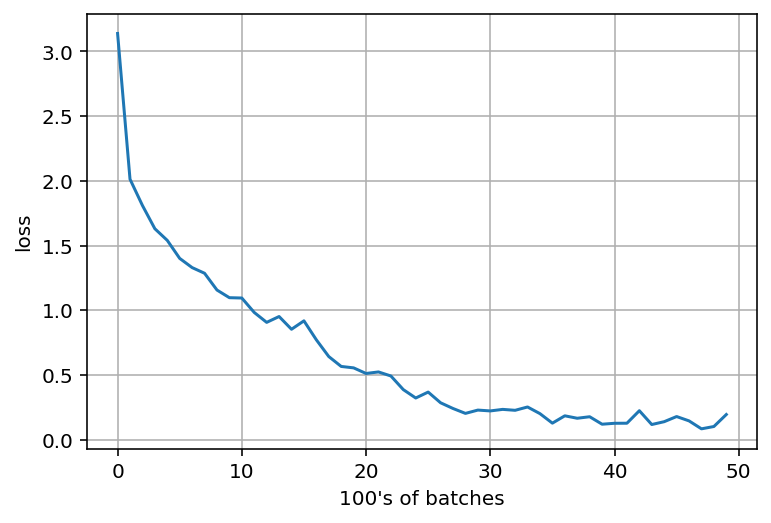

In [824]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('100\'s of batches')
plt.ylabel('loss')
plt.grid(True)
# plt.ylim(0, 2.5) # consistent scale
plt.show()

## Test the Trained Network

In [830]:
def test_network(model):
    # initialize tensor and lists to monitor test loss and accuracy
    test_loss = torch.zeros(1)
    class_correct = list(0. for i in range(7))
    class_total = list(0. for i in range(7))

    # set the module to evaluation mode
    model.eval()

    for batch_i, (mfccs, targets) in enumerate(test_loader):

        log_probs = model(mfccs.float())

        # calc. loss
        loss = criterion(log_probs, targets.long())

        # update average test loss
        test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))

        # get preds class fro the max. value
        _, predicted =  torch.max(log_probs.data, 1)

        # compare preds to true label
        correct = np.squeeze(predicted.eq(targets.data.view_as(predicted)))

        # calc. test accuracy for *each object class
        for i in range(8):
            target = targets.data[i]
            class_correct[target] += correct[i].item()
            class_total[target] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

    for i in range(7):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% ("%2d/%2d")' % (
                    emo_lookup[index_to_letter[i]], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)'% \
                  (emo_lookup[index_to_letter[i]]))


    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
                 100. * np.sum(class_correct) / np.sum(class_total),
          np.sum(class_correct), np.sum(class_total)))

In [831]:
test_network(mlp)

Test Loss: 2.032392

Test Accuracy of anger: 72%("16/22")
Test Accuracy of boredom: 66%("10/15")
Test Accuracy of disgust: 50%(" 5/10")
Test Accuracy of anxiety: 50%(" 6/12")
Test Accuracy of happiness: 26%(" 4/15")
Test Accuracy of sadness: 75%("12/16")
Test Accuracy of neutral: 85%("12/14")

Test Accuracy (Overall): 62% (65/104)


In [827]:
print(f'Training loss: {training_loss[-1]}')

Training loss: 0.19518463202985004


Model is overfiting.

## On Convolutional NN

In [1030]:
class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.batchnorm = nn.BatchNorm2d(32)
        
        
        self.maxpool =  nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        self.fc= nn.Linear(384, 50)
        
        self.main =  nn.Linear(50, 7)
        
        self.dropout =  nn.Dropout2d(0.3)
        
    def forward(self, x):
  
        x = F.relu(self.batchnorm(self.maxpool(self.conv1(x))))
        x = F.relu(self.maxpool(self.conv2(x)))
       
        x = x.view(x.size(0), -1)
#         print(x.shape)

        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = self.main(x)
        
#         return x
        return F.log_softmax(x, dim=1)
    
    
cnn = CNNModel()
print(cnn)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=384, out_features=50, bias=True)
  (main): Linear(in_features=50, out_features=7, bias=True)
  (dropout): Dropout2d(p=0.3, inplace=False)
)


In [1031]:
criterion = nn.NLLLoss()

# using cross entropy whcih combines softmax and NLL loss
# criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(cnn.parameters(), lr=3e-4)

In [1032]:
def train_network(model, epochs):
#     epochs = 50
    running_loss = 0
    print_every = 40
    
    loss_over_time = [] # to track the loss as the network trains

  

    for e in range(epochs):
        
        running_loss = 0.0

        for i, (mfcc, targets) in enumerate(train_loader):
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            log_prob = model(mfcc.float())
    
            #calculate the loss
            loss = criterion(log_prob, targets.long())
            
            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if i % print_every == 39:    # print every 100 batches
                avg_loss = running_loss/print_every
                # record and print the avg loss over the 100 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(e + 1, i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time
        
# call train
training_loss = train_network(cnn, 50)

Epoch: 1, Batch: 40, Avg. Loss: 1.8615150958299638
Epoch: 2, Batch: 40, Avg. Loss: 1.6580480575561523
Epoch: 3, Batch: 40, Avg. Loss: 1.4968902528285981
Epoch: 4, Batch: 40, Avg. Loss: 1.4734163403511047
Epoch: 5, Batch: 40, Avg. Loss: 1.4068597689270974
Epoch: 6, Batch: 40, Avg. Loss: 1.4061472311615943
Epoch: 7, Batch: 40, Avg. Loss: 1.3239345714449882
Epoch: 8, Batch: 40, Avg. Loss: 1.2646059662103653
Epoch: 9, Batch: 40, Avg. Loss: 1.2443075358867646
Epoch: 10, Batch: 40, Avg. Loss: 1.1853988379240037
Epoch: 11, Batch: 40, Avg. Loss: 1.114008492231369
Epoch: 12, Batch: 40, Avg. Loss: 1.127010777592659
Epoch: 13, Batch: 40, Avg. Loss: 1.070884969830513
Epoch: 14, Batch: 40, Avg. Loss: 1.1063340783119202
Epoch: 15, Batch: 40, Avg. Loss: 0.9914398238062858
Epoch: 16, Batch: 40, Avg. Loss: 0.9882619947195053
Epoch: 17, Batch: 40, Avg. Loss: 0.8782211408019066
Epoch: 18, Batch: 40, Avg. Loss: 0.9142173297703267
Epoch: 19, Batch: 40, Avg. Loss: 0.9171179935336113
Epoch: 20, Batch: 40, Av

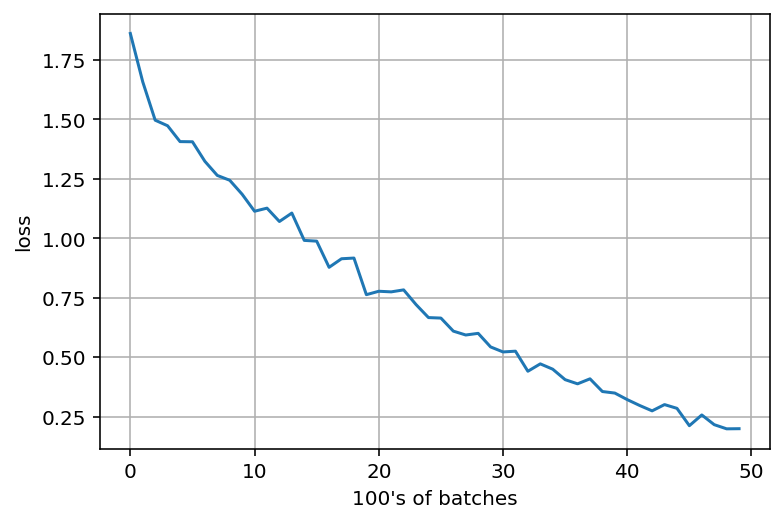

In [1033]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('100\'s of batches')
plt.ylabel('loss')
plt.grid(True)
# plt.ylim(0, 2.5) # consistent scale
plt.show()

In [1036]:
test_network(cnn)

Test Loss: 1.121224

Test Accuracy of anger: 65%("15/23")
Test Accuracy of boredom: 71%("10/14")
Test Accuracy of disgust: 40%(" 4/10")
Test Accuracy of anxiety: 75%(" 9/12")
Test Accuracy of happiness: 33%(" 5/15")
Test Accuracy of sadness: 68%("11/16")
Test Accuracy of neutral: 64%(" 9/14")

Test Accuracy (Overall): 60% (63/104)


In [1037]:
print(f'Training loss: {training_loss[-1]}')

Training loss: 0.1995795054361224
